In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses, initializers
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import pandas as pd
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
physical_gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

In [7]:
train_dir = "dataset/train"
test_dir = "dataset/test"

train_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size=32, color_mode="grayscale" ,class_mode="input", target_size=(64, 64))
test_generator = train_datagen.flow_from_directory(test_dir, batch_size=32, color_mode="grayscale" ,class_mode="input", target_size=(64, 64))

train_num = train_generator.n
test_num = train_generator.n

Found 18000 images belonging to 1 classes.
Found 3600 images belonging to 1 classes.


In [8]:
it = iter(train_generator[0][0])

(64, 64, 1)


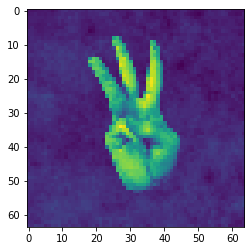

In [16]:
img = next(it)
print(img.shape)
plt.imshow(img)
plt.show()

In [10]:
from utils.models import create_vae_model
from utils.losses import reconstruction_loss
from utils.callbacks import SaveDecoderOutput, SaveDecoderModel

In [19]:
log_dirs = 'logs/fingers_1'
model_dir = log_dirs + '/models'
os.makedirs(model_dir, exist_ok=True)
model_tb = keras.callbacks.TensorBoard(log_dir=log_dirs)
model_sdw = SaveDecoderModel(model_dir + '/best_model.h5', monitor='val_loss')
model_testd = SaveDecoderOutput(64, log_dir=log_dirs)

In [17]:
# create vae model
input_shape = (64, 64, 1)
latent_dim = 2
vae_model = create_vae_model(input_shape, latent_dim)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 64)   18496       conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 16, 16, 64)   36928       conv2d_7[0][0]                   
____________________________________________________________________________________________

In [20]:
# training
optimizer = tf.keras.optimizers.RMSprop()
vae_model.compile(optimizer, loss=reconstruction_loss)
# vae_model.fit(train_data, epochs=100, validation_data=test_data, callbacks=[model_tb, model_sdw, model_testd])
batch_size = 128
epochs = 100
steps_per_epoch = int(train_num / batch_size)

In [21]:
trainHistory = vae_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[model_tb, model_sdw, model_testd]
)

Epoch 1/100
140/140 [==============================] - 8s 49ms/step - loss: 2231.7344 - val_loss: 2165.0276
Epoch 2/100
140/140 [==============================] - 6s 42ms/step - loss: 2170.0920 - val_loss: 2170.1753
Epoch 3/100
140/140 [==============================] - 6s 44ms/step - loss: 2168.7034 - val_loss: 2160.7856
Epoch 4/100
140/140 [==============================] - 6s 43ms/step - loss: 2156.7671 - val_loss: 2153.0498
Epoch 5/100
140/140 [==============================] - 6s 44ms/step - loss: 2148.7559 - val_loss: 2138.8655
Epoch 6/100
140/140 [==============================] - 6s 42ms/step - loss: 2144.6187 - val_loss: 2146.5049
Epoch 7/100
140/140 [==============================] - 6s 41ms/step - loss: 2139.9861 - val_loss: 2138.8562
Epoch 8/100
140/140 [==============================] - 6s 43ms/step - loss: 2137.2505 - val_loss: 2128.6277
Epoch 9/100
140/140 [==============================] - 6s 42ms/step - loss: 2132.0161 - val_loss: 2129.9917
Epoch 10/100
140/140 [======

In [25]:
best_model = load_model("logs/fingers_1/models/best_model.h5")

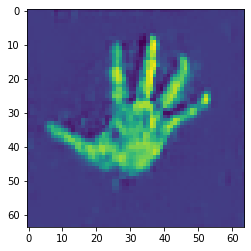

In [35]:
vector = (5, 5)
predicts = best_model.predict([vector])
img = predicts[0]
plt.imshow(img)
plt.show()

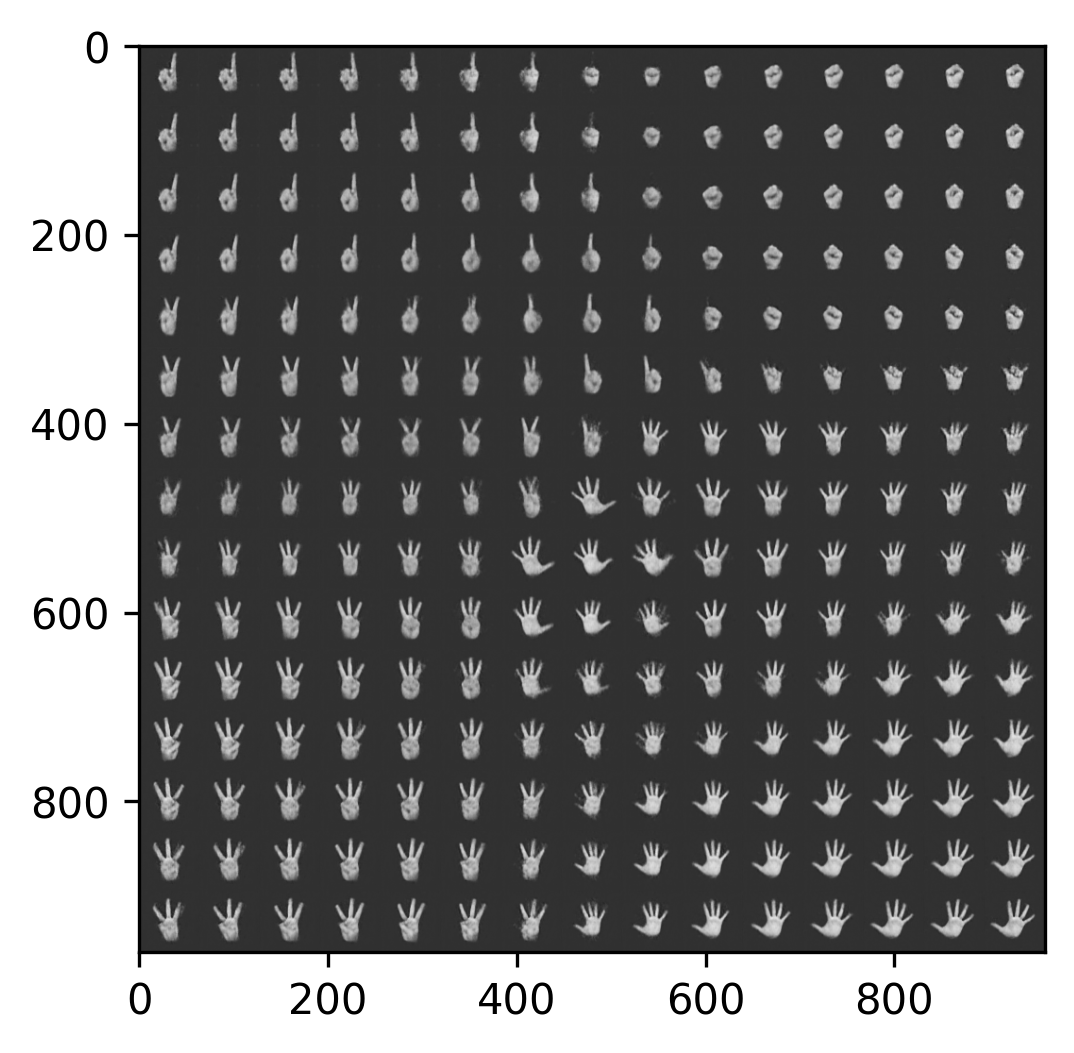

In [52]:
n = 15
rate = 2
grid_x = np.linspace(-rate, rate, n)
grid_y = np.linspace(-rate, rate, n)
size = 64
draw = np.zeros((size * n, size * n, 3))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        img = best_model.predict(z_sample)[0]
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        draw[i * size: (i + 1) * size, j * size: (j + 1) * size] = img
plt.figure(dpi=300)
plt.imshow(draw)
plt.show()